# Grade: /100 pts

# Assignment 04: Confidence Intervals & Bootstrap

Once you are finished, ensure to complete the following steps.
1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.
2.  Fix any errors which result from this.
3.  Repeat steps 1. and 2. until your notebook runs without errors.
4.  Submit your completed notebook to OWL by the deadline.

In [1]:
# Add the necessary imports for this homework 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t

### Question 1: /10pts

Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005, including their age (age - in years), weight (wt - in pounds), height (ht - in inches), and overall ability (overall, ranked on a combined scale, with higher values being better). 

Perform the following actions:
1. Fit a linear model of the influence of weight (`wt`) on the overall ability (`overall`) using a quadratic regression model from sklearn, as done in the lab (but with quadratic fit instead of cubic).  Call your fitted model `model`.  
2. Make a scatter plot of the weight (x-axis) against overall (y-axis). Be sure to label the plot axes.
3. Plot the predicted values for the overall ability for 170-250 pounds as a line plot. 
4. Calculate the r-squared value for this fit directly from the residuals (not using the built-in function).

Training rsquared is  0.100224023555879


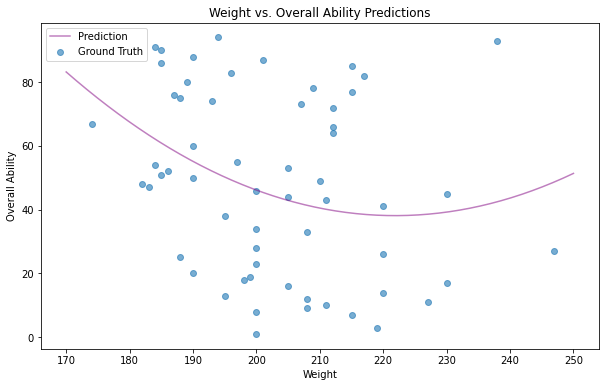

In [2]:
df = pd.read_csv("hockey_draftees_2005.csv")

# Create and fit the model 
model = sklearn.linear_model.LinearRegression()
X = np.c_[df.wt, df.wt**2]
model.fit(X, df.overall)

# Make the scatter plot 
linspace = np.linspace(170, 250, 50)
X_pred = np.c_[linspace, linspace**2]
p_overall = model.predict(X_pred)

#Generate and plot the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df.wt, df.overall, label='Ground Truth', alpha=0.6)
plt.plot(linspace, p_overall, color='purple', label='Prediction', alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Overall Ability')
plt.legend()
plt.title('Weight vs. Overall Ability Predictions')

# Calculate residuals (R2) and print them 
y = np.asarray(df.overall)
ypred = model.predict(X)
residuals = np.subtract(y, ypred)
sum_of_squares = np.sum(np.square(residuals))
R2 = 1 - (sum_of_squares / np.sum(np.square(y - np.mean(y))))

print('Training rsquared is ', R2)
plt.show()


### Question 2:  /15pts
### Bootstrap confidence intervals on parameters

How confident can we be about the relation between weight and the overall ranking? 
To judge this, we need confidence intervals on the linear and quadratic coefficients. 

Modify the function `BootstrapCoef` from lab 04 - part 2 to conduct a boostrap analysis for this regression model. Input arguments to this function should be:  

* `data`, which is a dataframe having columns 'weight' and 'overall'
* `numboot` which is an integer denoting how many bootstrap replications to perform.

Write `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  
Your function `bootstrap` should return:

- params: a numpy array of size [numboot,numParams] of bootstraped parameter values. The parameters are the intercept, the slope and the quadratic term of the linear regression model. 

*Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_.* 

Read through the documentation for `pd.DataFrame.sample` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)) to understand how to make the samples for each bootstrap run.

Then call the function to get 100 boostrap samples for your quadratic regression model of overall ability explained by weight. Make a joint scatter plot of the parameter value for the intercept and the quadratic coefficient. 

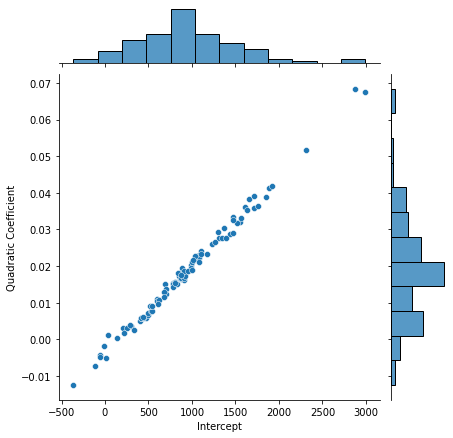

In [3]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data, numboot):
    # Write the function here
    regression = sklearn.linear_model.LinearRegression()
    n = len(data)
    theta = np.zeros((numboot, 3))

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_boot = np.c_[d.wt, d.wt**2]
        regression.fit(X_boot, d.overall)
        theta[i,0] = regression.intercept_
        theta[i,1] = regression.coef_[0]
        theta[i,2] = regression.coef_[1]

    return theta

# Run the function over your data
params = BootstrapCoef(df, 100)
# Make the scatterplot
ax = sns.jointplot(x=params[:,0], y=params[:,2])
ax.set_axis_labels('Intercept', 'Quadratic Coefficient')
plt.show()



### Question 3: /5pts

Make **a copy** of your data frame and subtract the mean weight from the column weight. Call the boostrap function with the modified data and provide a joint plot of the estimate for the intercept and the quadratic coefficient.  

Written answer: Compare this graph to the one from Question 2. Why do the two graphs look so different? How come the two parameters are so positively correlated in one case and nearly look independent in the other case? What is actually in common in the two cases? 

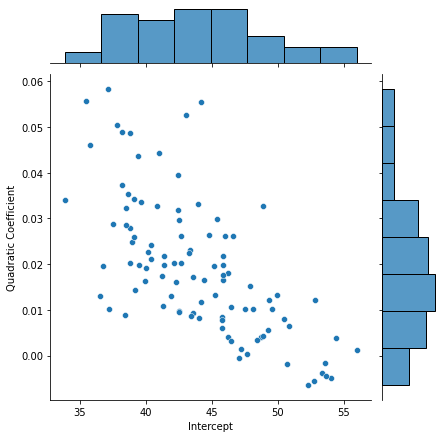

In [4]:
# Substract the mean weight from the weight column here
df_means = df.copy()
mean = df['wt'].mean()
df_means['wt'] -= mean
 
# Re-run the bootstrap algorithm over the new data here
params = BootstrapCoef(df_means, 100)
# Plot the new result here:
ax = sns.jointplot(x=params[:,0], y=params[:,2])
ax.set_axis_labels('Intercept', 'Quadratic Coefficient')
plt.show()

**Written answer:** The graphs look different because the intercept was previously arbitrary - it represented the skill of a player with a weight of 0 pounds, while no players have a weight below 170 pounds; we had no data to model what happens near x = 0. In the second graph, the intercept has a meaning - it represents the skill level of a player of average weight. The two parameters are so positively correlated in the first case because the quadratic coefficient has a very high influence on the intercept since the minimum is at around 200. They look independent in the second case because the intercept now has a meaning (skill of average weighted player) and that meaning is not correlated with the quadratic coefficient (how skill is affected as the player's weight is further away from the average). The distribution and range of the quadratic coefficient are similar in both cases. 

### Question 4: /10pts

Plot the bootstrap estimates for the quadratic coefficient as a histogram (use the estimates from the model fitted in Question 3).  Use your samples to compute a 95% confidence interval. Note that the CI should be constructed around the sample estimate of the quadratic coefficient. 

Written answer: How can you interpret this confidence interval?  

My confidence interval is between -0.004646918387067575  and  0.054127037790836025


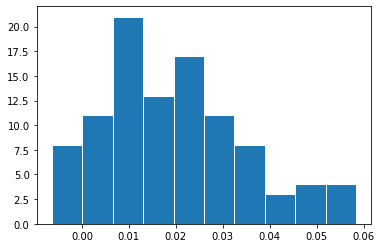

In [5]:
# Plot histogram 
estimates = params[:,2]
plt.hist(estimates, edgecolor = 'white')

# Calculate bootstrap interval
ci_lower, ci_upper = np.quantile(estimates, [0.025, 0.975])
#boot_ci = [ci_upper, ci_lower]
print('My confidence interval is between', ci_lower, ' and ', ci_upper)
plt.show()

**Written answer:** There is a 95% probability that the true (population) quadratic coefficient is between -0.003 and 0.049.

### Question 5: /15pts
Modify the function `BootstrapPred` from lab04 to bootstrap your fit and generate a prediction from each of these bootstrapped models.  

Draw again a scatter plot of weight against overall ability. Plot the predictions from the 20 fitted bootstrap models to derive predictions for the weight ranging from 170 to 250. Draw all these predicted quadratic functions onto your scatter plot. 

Written answer: Where (what weight range) are we most uncertain in our prediction about the overall ability of a player? Why?

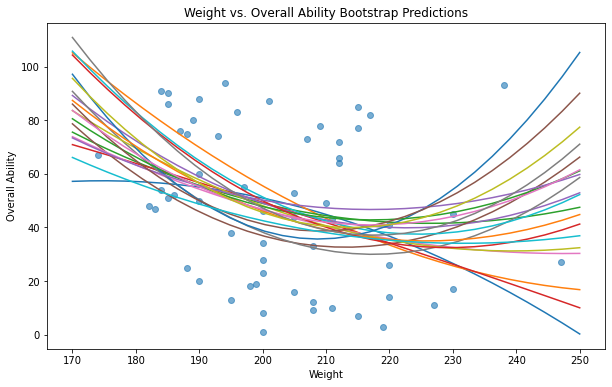

In [6]:
# Write a Bootstrap function that records the fitted models 
def BootstrapPred(data,xp):
    regression = sklearn.linear_model.LinearRegression()
    numboot = 20
    n = len(data)
    X_pred = np.c_[xp, xp**2]
    y_pred = np.zeros((numboot,X_pred.shape[0]))    

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_boot = np.c_[d.wt, d.wt**2]
        regression.fit(X_boot,d.overall)
        y_pred[i,:] = regression.predict(X_pred)

    return y_pred

# Get predictions from 20 bootstrapped models 
x_pred = np.linspace(170, 250, 30)
y_pred = BootstrapPred(df, x_pred)

# Make a scatterplot and draw the 20 lines  
plt.figure(figsize=(10, 6))
plt.scatter(df.wt, df.overall, alpha=0.6)
plt.xlabel('Weight')
plt.ylabel('Overall Ability')
plt.title('Weight vs. Overall Ability Bootstrap Predictions')

for i in range(20):
    plt.plot(x_pred, y_pred[i,:])

plt.show()


**Written answer:** We are the most uncertain about the overall ability of players in the upper weight range (230+) because the bootstrapped model predictions vary significantly in this range.

### Question 6:  /15pts

Now, let's see how well our model performs out of sample, i.e. for the overall ranking of hockey players in different years.  Load in the `hockey_draftees_test.csv` file into a dataframe.  
Use your fitted `model` to make predictions on the test data. **Do not refit your model using the test data.**

Make a scatter plot of the test data (weight against overall) and superimpose the prediction of the model. 
To evaluate this prediction, calculate the r-square value for the out of sample (oos) data.  Don't rely on a built-in function, but calculate the predictive r-square from the test data and your prediction directly. 

Written answer: What might explain the terrible performance of your model? 

Out of sample rsquared is  -0.7358097599787561


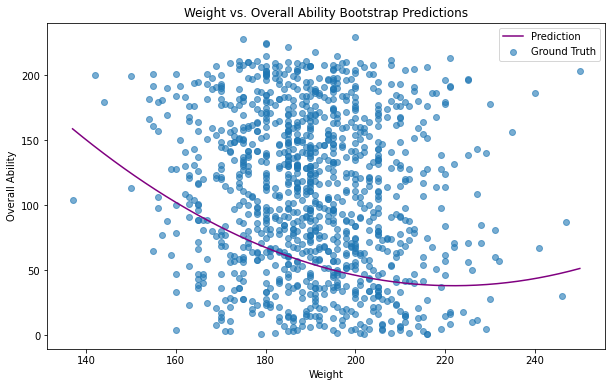

In [7]:
df_test = pd.read_csv('hockey_draftees_test.csv')

# Make the scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(df_test.wt, df_test.overall, label='Ground Truth', alpha=0.6)

# Generate and plot the predicted values
linspace = np.linspace(df_test.wt.min(), df_test.wt.max(), 50)
X_pred = np.c_[linspace, linspace**2]
p_overall = model.predict(X_pred)
plt.plot(linspace, p_overall, color='purple', label='Prediction', alpha=1)

plt.xlabel('Weight')
plt.ylabel('Overall Ability')
plt.legend()
plt.title('Weight vs. Overall Ability Bootstrap Predictions')

# Now do the prediction for the test data and compute R2
X = np.c_[df_test.wt, df_test.wt**2]
y = np.asarray(df_test.overall)
ypred = model.predict(X)
residuals = np.subtract(y, ypred)
sum_of_squares = np.sum(np.square(residuals))
R2 = 1 - (sum_of_squares / np.sum(np.square(y - np.mean(y))))

print('Out of sample rsquared is ', R2)
plt.show()


**Written answer:** The terrible performance of the model can be explained by the fact that the model was fit to only 2005 data, therefore a wider variety of data would have helped create a better model. There is also no trend in the test data. 

### Question 7: /10pts 
In this question, you will construct a confidence interval for the sample mean, not using the normal distribution, but the t-distribution (see end of lecture 4.3), which is more accurate for small sample sizes.  

The $100(1-\alpha)\%$ confidence interval is 

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.  
Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and 

* The lower and upper bounds of the 95% confidence interval for the mean of `data`.  Ensure these are returned in a numpy array of shape (2,)

To get the appropirate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution.  Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.

Here is the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html


In [8]:
def confidence_interval(data):

    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternatively, you can use scipy.stats.sem to compute
    #The standard error
    n = data.size
    quantile = t.ppf(1-0.05/2, df=n-1)
    estimated_mean = data.mean()
    estimated_standard_error = data.std(ddof=1)/np.sqrt(data.size)
    bounds = estimated_mean + quantile * estimated_standard_error * np.array([-1,1])
    
    return estimated_mean, bounds

### Question 8: /15pts

The "95% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 95%.  That is to say **if I construct 100 95% confidence intervals for the sample mean again and again from the same data generating mechanism, 95 of these intervals I construct will contain the true population mean**.

Write a function called `ci_simulation` that runs some simulations to show this is the case.  From a standard normal distirbution, sample 25 observations and construct a confidence interval.  Do this 20 times and plot the intervals using `matplotlib.pyplot.errorbar`.  Color the bar red if the confidence interval does not capture the true mean and blue if it does.  

If you are unfamilliar with `matplotlib.pyplot.errorbar`, I highly suggest reading Matplotlib's excellent documentation which has some examples at the bottom of the webpage. The documentation for `matplotlib.pyplot.errorbar` is in [this link](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html). 

If you are unfamilliar with how to sample random numbers, I suggest you look at `numpy.random.normal`.  Try searching for the documentation for that function yourself if you need to.

*Note that intercept and slope regressors are highly colinear - as we did not subtract the mean of weight before thre regression.*

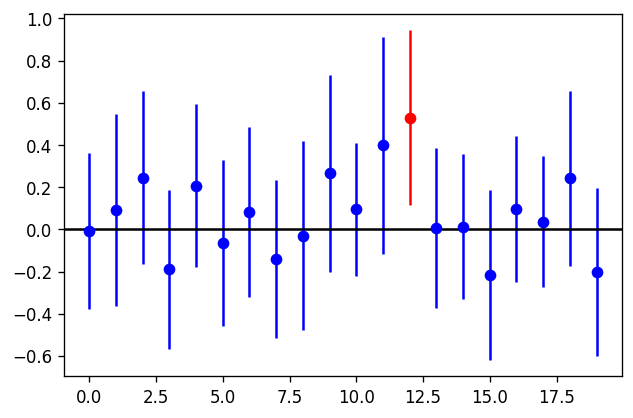

In [9]:
def ci_simulation():
    # Set the random seed to always get the same random numbers. 
    # This is for Reproducibility. 
    np.random.seed(4)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):

        #Draw 25 observations from a standard normal
        data = np.random.normal(size = 25)

        # Compute what we need for the CI, namely the mean and the bounds
        mean, bounds = confidence_interval(data)
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1.0/2*(bounds[1] - bounds[0])
        ax.errorbar(i, mean, yerr=interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()


### Question 9: /5pts

If you haven't changed the random seed from 4 and if you implemented the solution correctly, you should have only one red interval.

Answer the following below in no more than 3 sentences:

**a)** How many red intervals did we expect to see?  What is your justifiation for this?

Changing the random seed might affect how many red intervals you see.  Try changing the random seed in your function to 3. This will yield two red intervals (which is different than what you should expect to see). 

**b)** Why does the simulation sometimes deviate from the predicted results 


**Written Answer:** 

**a)** We expected to see 1 red interval because we constructed 20 confidence intervals. Since we would expect 95% of these to contain the true population mean, we would expect 5% of 20 to not contain the true population mean, which is 1.

**b)** The simulation sometimes deviates from the predicted results because it is random. We can expect a certain number of trials that don't capture the true mean, however that may not always be the case due to randomness.